In [1]:
%%sh
#git clone https://github.com/jcboyd/multi-cell-line.git
#ln -s multi-cell-line/src

computing normalization parameters
computing normalization parameters


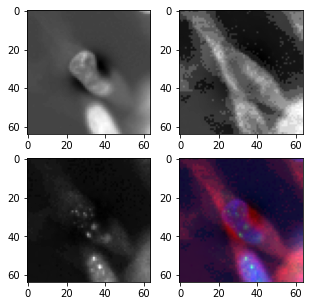

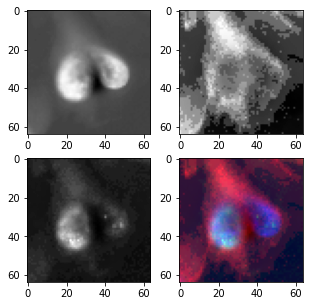

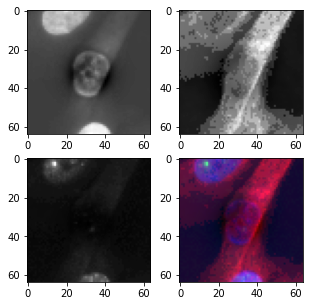

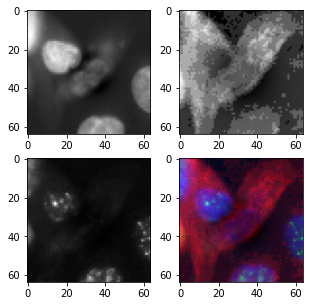

In [2]:
from socket import gethostname

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torchvision

from janus.datasets import Boyd2019
from janus.losses import ContrastiveLoss
from janus.networks import SiameseNet
from janus.viz import plot_cell, tsne, umap


if gethostname() == 'tael.local':
    from tqdm.notebook import trange, tqdm
else:
    from tqdm import trange, tqdm

data_path = 'data/boyd_2019'
metadata_file = 'data/boyd_2019_PlateMap-KPP_MOA.xlsx'

metadata = Boyd2019.read_metadata(metadata_file)

# filter by 2 moas and make train test
metadata = metadata.loc[metadata.moa.isin(['Neutral', 'EGF Receptor Kinase Inhibitor'])]
train_metadata = metadata.sample(frac=0.7)
test_metadata = metadata.drop(train_metadata.index)

boyd2019 = Boyd2019('data/boyd_2019/', train_metadata, padding=64, scale=0.5)

for i in np.random.randint(1, 1000, 4):
    plot_cell(boyd2019.dataset_1[i][0])

In [3]:
boyd2019.metadata.head(10)

,plate,id,well,content,concentration,moa,target1,target2,source
13,Plate_KinInh_1_P1_P1,A - 14,A14,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
9,Plate_KinInh_1_P1_P1,A - 10,A10,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
362,Plate_KinInh_1_P1_P1,P - 03,P03,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
62,Plate_KinInh_1_P1_P1,C - 15,C15,AG-825,10 µM,EGF Receptor Kinase Inhibitor,HER1-2,NaN,https://www.caymanchem.com/product/10010243
21,Plate_KinInh_1_P1_P1,A - 22,A22,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
106,Plate_KinInh_1_P1_P1,E - 11,E11,Tyrphostin AG 1478,10 µM,EGF Receptor Kinase Inhibitor,EGFRK,NaN,http://www.selleckchem.com/products/ag-1478-ty...
96,Plate_KinInh_1_P1_P1,E - 01,E01,Tyrphostin 46,10 µM,EGF Receptor Kinase Inhibitor,"EGFRK, PDGFRK",NaN,http://www.abcam.com/tyrphostin-46-ag-99-ab141...
70,Plate_KinInh_1_P1_P1,C - 23,C23,Tyrphostin 25,10 µM,EGF Receptor Kinase Inhibitor,EGFRK,NaN,http://www.enzolifesciences.com/BML-EI187/tyrp...
7,Plate_KinInh_1_P1_P1,A - 08,A08,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
3,Plate_KinInh_1_P1_P1,A - 04,A04,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide


In [4]:
print('Dataset 1: %d cells' % len(boyd2019.dataset_1))
print('Dataset 2: %d cells' % len(boyd2019.dataset_2))

Dataset 1: 11057 cells
Dataset 2: 8052 cells


# Data generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 1 1 0 0 1 1]


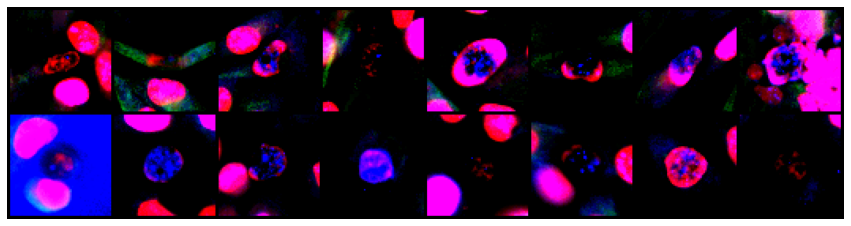

In [5]:
def imshow(img, text=None, should_save=False):

    fig, ax = plt.subplots(figsize=(15, 5))

    npimg = img.numpy()

    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

vis_dataloader = DataLoader(boyd2019,
                            shuffle=True,
                            num_workers=8,
                            batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[2]),0)
print(example_batch[4].numpy())
imshow(torchvision.utils.make_grid(concatenated))

# Training

In [6]:
# training params
train_batch_size = 64
train_number_epochs = 10
train_hosts = ['lion','inu','kuma']
# train_hosts.extend(['tael.local'])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

if (gethostname() in train_hosts):

    train_dataloader = DataLoader(boyd2019,
                                  shuffle=True,
                                  num_workers=8,
                                  batch_size=train_batch_size)

    net = SiameseNet().to(device)
    criterion = ContrastiveLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.0005)
    
    with trange(train_number_epochs) as epochs:
        for epoch in epochs:
            with tqdm(enumerate(train_dataloader,0), total = len(boyd2019)) as tepoch:
                for i, data in tepoch:
                    img0, moa0, img1, moa1, label = data
                    img0, img1, label = img0.to(device), img1.to(device), label.to(device)
                    
                    optimizer.zero_grad()
                    output1,output2 = net(img0,img1)
                    loss = criterion(output1,output2,label)
                    loss.backward()
                    optimizer.step()

                    tepoch.set_postfix(loss=loss.item())

            torch.save(net.state_dict(), 'siamese_%04d.torch' % epoch)

cpu


# Testing

In [7]:
# load saved net
net = SiameseNet().to(device)
net.load_state_dict(torch.load('sn_dropout_0.5_margin_1.0_seed_5_epoch_100.torch',
                               map_location=torch.device('cpu')))
net = net.eval()

In [8]:
# get test set: different wells than training
# test_metadata = pd.DataFrame({'well': ['C01', 'D02'], 'moa': [1, 2]})
test_boyd2019 = Boyd2019('data/boyd_2019/', test_metadata)

test_dataloader = DataLoader(test_boyd2019,
                             shuffle=True,
                             num_workers=8,
                             batch_size=train_batch_size)

computing normalization parameters
computing normalization parameters


In [9]:
from janus.viz import norm_crop_for_vis

# sample test set
embedding = np.empty((0, 256))
moas = []
cell_line = np.empty((0,))

all_imgs = []

for i, data in enumerate(test_dataloader, 0):
    img0, moa0, img1, moa1, _ = data
    img0, img1 = img0.to(device), img1.to(device)
    output1, output2 = net(img0, img1)

    embedding = np.concatenate((embedding, output1.detach().numpy(), output2.detach().numpy()))
    cell_line = np.concatenate((cell_line,
                                np.repeat('mda468', output1.shape[0]),
                                np.repeat('mda231', output2.shape[0])))
    moas.extend(moa0)
    moas.extend(moa1)

    normed_img0 = torch.cat([norm_crop_for_vis(img)[None] for img in img0], axis=0)
    normed_img1 = torch.cat([norm_crop_for_vis(img)[None] for img in img1], axis=0)

    all_imgs.append(normed_img0)
    all_imgs.append(normed_img1)

    if i == 100:
        break

all_imgs = torch.cat(all_imgs).cpu()

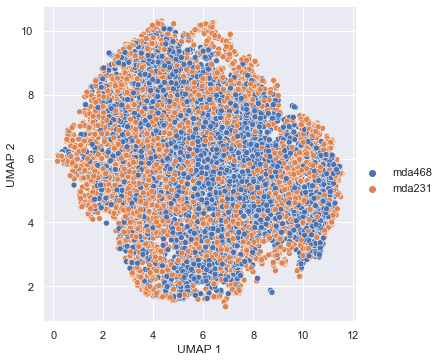

In [10]:
from umap import UMAP
from janus.viz import xy_plot

x_emb = UMAP().fit_transform(embedding)
xy_plot(x_emb, cell_line, 'UMAP')

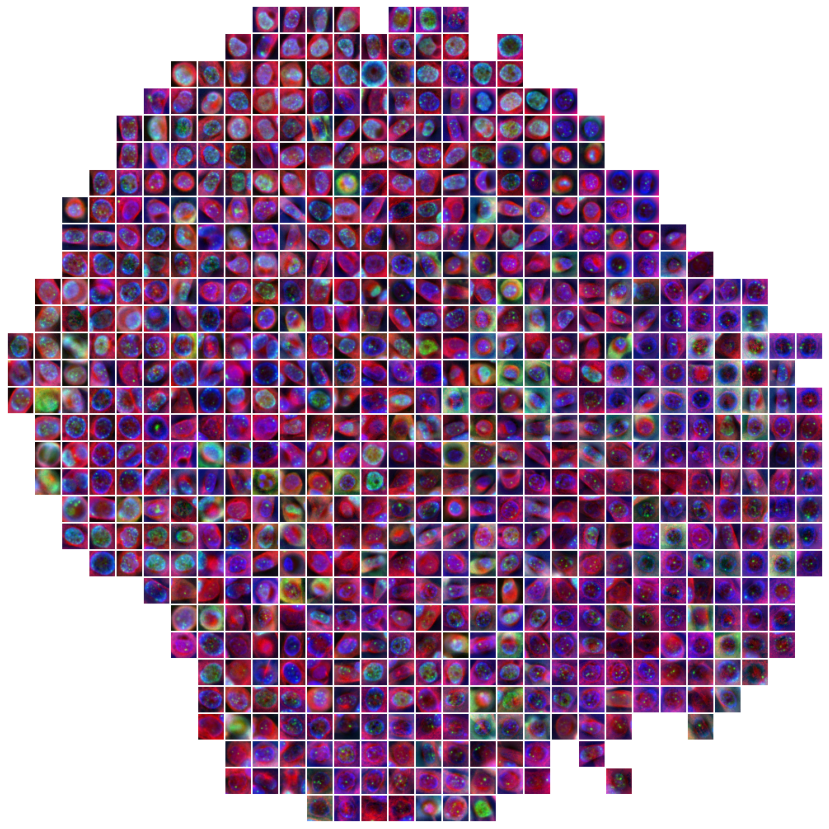

In [11]:
from janus.viz import plot_tiles
import matplotlib.patches as patches

canvas, img_idx_dict = plot_tiles(all_imgs, x_emb, 30, pad=1)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(canvas)
ax.axis('off')

palette = list(sns.color_palette().as_hex())

# for img_key in img_idx_dict.keys():
#     xmin, xmax, ymin, ymax = img_idx_dict[img_key]
#     cls = moas[img_key].item()
#     colour = palette[0] if cls == 1 else palette[1]
#     # Create a Rectangle patch
#     line_width = 3
#     rect = patches.Rectangle((xmin+line_width, ymin+line_width), xmax-xmin-2*line_width, ymax-ymin-2*line_width,
#                              linewidth=line_width, edgecolor=colour, facecolor='none')
#     # Add the patch to the Axes
#     ax.add_patch(rect)

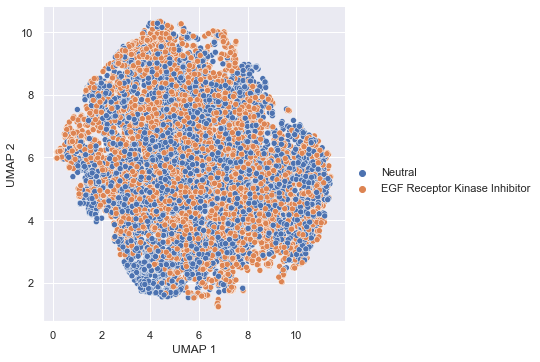

In [12]:
umap(embedding, moas)

# MoA Prediction

In [13]:
df_embeddings = pd.DataFrame()

for crop, meta in test_boyd2019.dataset_1 + test_boyd2019.dataset_2:
    embedding = net.embedding(crop[None])
    df_emb = pd.DataFrame(embedding.detach().numpy())
    df_emb['well'] = meta['well']
    df_emb['moa'] = meta['moa']
    df_embeddings = pd.concat([df_embeddings, df_emb])

df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,well,moa
0,-0.021750,-0.026610,0.002150,-0.076062,-0.049328,0.013002,0.009969,-0.036191,0.023697,0.167945,...,0.063877,-0.019087,0.089997,0.131989,-0.053472,-0.086183,-0.072664,0.132823,A01,Neutral
0,-0.053857,0.003519,-0.023203,-0.066739,-0.020939,-0.038857,0.020028,0.014708,-0.000674,0.124349,...,0.025901,-0.002539,0.085519,0.122236,-0.037691,-0.093141,-0.046283,0.068773,A01,Neutral
0,-0.037661,-0.011018,-0.029824,-0.083639,-0.002897,-0.054741,0.004385,-0.009240,-0.011167,0.132358,...,0.041560,-0.007575,0.038100,0.102176,-0.027950,-0.092682,-0.076176,0.051003,A01,Neutral
0,-0.034424,0.006943,-0.032629,-0.071278,-0.016169,-0.047495,0.008615,-0.007401,-0.011246,0.112417,...,0.039612,-0.009710,0.059996,0.106670,-0.028541,-0.083622,-0.070778,0.074844,A01,Neutral
0,-0.035609,-0.005309,-0.043821,-0.078047,-0.013663,-0.036616,0.006348,-0.003440,-0.008666,0.110224,...,0.042043,-0.000970,0.071452,0.095865,-0.036781,-0.078332,-0.053292,0.085082,A01,Neutral


In [14]:
from janus.lococv import construct_profiles, lococv

df_profiles = construct_profiles(df_embeddings, range(256))
confusion = lococv(df_profiles, test_boyd2019.metadata.set_index('well'))
ae_acc = np.trace(confusion) / np.sum(confusion)
print('Accuracy: %.04f' % ae_acc)

Accuracy: 0.8667


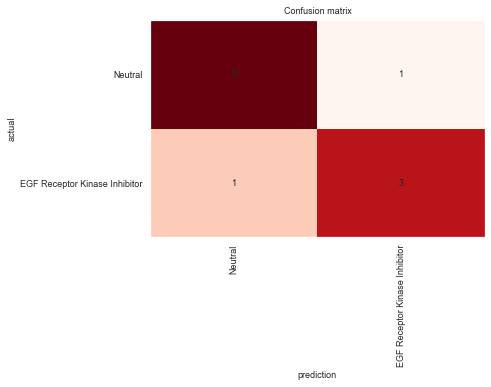

In [15]:
from janus.viz import plot_confusion_matrix

plot_confusion_matrix(confusion, test_boyd2019.metadata.moa.unique())